# Importing data

In [1]:
import pandas as pd
from datetime import datetime, date
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer, StandardScaler   
import warnings
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-muted')

Using TensorFlow backend.


In [2]:
data = pd.read_json('sherdog/data/final.json')

# Data preparation

In [3]:
def get_method(x):
    """Helper function for """
    if x:
        x = x.strip()
    else:
        x = ''
    methodsmap = {'': 'decision', '(draw)': 'decision', '(forfeit)': 'ko',
                  '(head kick and punches)': 'ko', '(illegal slam)': 'ko',
                  '(no contest)': 'decision', '83185': 'decision', '_____È': 'decision',
                  'armbar': 'submission', 'brabo choke': 'submission', 
                  'bulldog choke': 'submission', 'choke': 'submission', 'decision': 'decision', 
                  'decision unanimous)': 'decision', 'decisionn': 'decision', 
                  'decisions': 'decision', 'decison': 'decision', 'default': 'decision',
                  'disqualification': 'decision', 'dq': 'decision', 'draw': 'decision',
                  'ee stoppage from a cut)': 'ko','forfeit': 'ko','igor lumpov': 'submission',
                  'isaac yap': 'submission','k)': 'ko','knockout': 'ko','ko': 'ko','ko/tko': 'ko',
                  'ko/tko punches': 'ko','ko/tko, ground and pound': 'ko',
                  'majority draw': 'decision','mata leon': 'submission','method': 'decision',
                  'n/a': 'decision','nc': 'decision','no contest': 'decision',
                  'no contrst': 'decision','points': 'decision','retirement': 'decision',
                  'rich mitchell': 'decision','s': 'submission','split decision': 'decision',
                  'subimssion': 'submission','submision': 'submission','submisison': 'submission',
                  'submissio': 'submission','submissiom': 'submission','submission': 'submission',
                  'submission armbar': 'submission','submission rear naked choke': 'submission',
                  'submission verbal tap out': 'submission','submission(triangle choke)': 'submission',
                  'submission-guillotine choke': 'submission','submisson': 'submission',
                  'submssion': 'submission','tapout': 'submission','techincal submission': 'submission',
                  'technial submission': 'submission','technical decision': 'decision',
                  'technical submission': 'submission','technical sumbission': 'submission',
                  'tko': 'ko','tko(punches)': 'ko','tko(strikes)': 'ko','tko/medical stoppage': 'ko',
                  'towel': 'ko','ubmission': 'submission','unanimous decision': 'decision',
                  'verbal submission': 'submission','walkover': 'decision','yko': 'ko'}
    return methodsmap[x]
    
    

def parse_date(timeinmilis):
    """Helper method for parsing date in miliseconds."""
    try:
        timestamp = timeinmilis / 1000
        res = datetime.utcfromtimestamp(timestamp)
        return res
    except:
        return date(2000, 1, 1)
    

def clean_last_fight(x):
    """Cleans time since last fight calculations."""
    # If result is lower than 0 return 0
    # It happens when it's fighters first fight
    if x <= 0.0:
        return 0.0
    else:
        return x

    
def get_label(event_timestamp):
    """Attaches the label based on fights date."""
    event_date = event_timestamp.date()
    if event_date >= date(2015, 1, 1):
        return 'test'
    else:
        return 'train'

    
def flatten(data, detailed=False):
    """Flattens the dataset features form dict
    to a columns."""
    X = pd.DataFrame()
    if detailed:
        X['target'] = data['method'].apply(get_method)
        X['target'] = X['target'] + data['result']
    else:
        X['target'] = data['result'].map({'win': 1, 'loss': 0})
    for fighter in ['fighter', 'opponent']:
        for key in ['started']:
            curr = '{}_{}'.format(fighter, key)
            first_fight_date = data[fighter].apply(lambda x: parse_date(x[key]))
            event_date = data['date']
            X[curr] = event_date - first_fight_date
            X[curr] = X[curr].apply(lambda x: clean_last_fight(x.days))
            
            
        for key in ['since_last_fight']:
            curr = '{}_{}'.format(fighter, key)
            X[curr] = data[fighter].apply(lambda x: x[key])

        # Cumulative stats
        stats = 'cumulative'
        for key in ['loss', 'win']:
            for result in ['loss', 'win']:
                for method in ['decision', 'knockout', 'submission', 'total']:
                    curr = '{}_{}_{}_{}_{}'.format(fighter, stats, key, result, method)
                    X[curr] = data[fighter].apply(lambda x: x[stats][key][result][method])
                    X[curr] = X[curr].apply(lambda x: float(x))

        # Historical stats
        stats = 'history'
        for result in ['loss', 'win']:
            for method in ['decision', 'knockout', 'submission', 'total']:
                curr = '{}_{}_{}_{}'.format(fighter, stats, result, method)
                X[curr] = data[fighter].apply(lambda x: x[stats][result][method])
                X[curr] = X[curr].apply(lambda x: float(x))
        for key in ['fights', 'positions', 'time']:
            curr = '{}_{}_{}'.format(fighter, stats, key)
            X[curr] = data[fighter].apply(lambda x: x[stats][key])
            X[curr] = X[curr].apply(lambda x: float(x))
        
        # Streak
        stats = 'streak'
        for result in ['loss', 'win']:
            curr = '{}_{}_{}'.format(fighter, stats, result)
            X[curr] = data[fighter].apply(lambda x: x[stats][result])
            X[curr] = X[curr].apply(lambda x: float(x))
    
    return X


def train_test_split(data):
    data['set'] = data['date'].apply(get_label)
    train = data[data['set'] == 'train']
    test = data[data['set'] == 'test']
    return train, test

def get_data(data, detailed=False, scaled=False):
    """Returns the dataset with train and test split"""
    train, test = train_test_split(data)
    
    xtrain = flatten(train, detailed)
    ytrain = xtrain['target']
    xtrain.drop(['target'], axis=1, inplace=True)
    xtrain.fillna(0, inplace=True)
        
    
    xtest = flatten(test, detailed)
    ytest = xtest['target']
    xtest.drop(['target'], axis=1, inplace=True)
    xtest.fillna(0, inplace=True)
    
    assert xtrain.shape[1] == xtest.shape[1]
    
    if scaled:
        # Scale data
        scaler = StandardScaler()
        scaler.fit(xtrain)

        xtrain = pd.DataFrame(scaler.transform(xtrain), columns=xtrain.columns)
        xtest = pd.DataFrame(scaler.transform(xtest), columns=xtest.columns)
    
    print('{:.2f}% ({}) of fights in the training dataset'.format(
        len(train)/len(data)*100, len(train)))
    print('{:.2f}% ({}) of fights in the testing dataset'.format(
        len(test)/len(data)*100, len(test)))
    
    return xtrain, xtest, ytrain, ytest

In [4]:
xtrain, xtest, ytrain, ytest = get_data(data, scaled=True)

78.39% (335978) of fights in the training dataset
21.61% (92636) of fights in the testing dataset


In [5]:
logreg = LogisticRegression()
logreg.fit(xtrain, ytrain)

print('LogisticRegression training {:.2f}%'.format(
    accuracy_score(ytrain, logreg.predict(xtrain))*100))
print('LogisticRegression testing {:.2f}%'.format(
    accuracy_score(ytest, logreg.predict(xtest))*100))
feats = {feature: importance for feature, importance in zip(xtrain.columns, logreg.coef_[0])}
importances = pd.DataFrame.from_dict(feats, orient='index')
importances = importances.rename(columns={0: 'Importance', 1: 'Feature'})
importances = importances.iloc[importances['Importance'].abs().argsort()].iloc[::-1]
importances.head(5)

LogisticRegression training 68.38%
LogisticRegression testing 67.21%


,Importance
fighter_cumulative_loss_win_submission,0.459607
opponent_cumulative_loss_win_submission,-0.459605
fighter_cumulative_win_win_submission,-0.326874
opponent_cumulative_win_win_submission,0.326872
fighter_cumulative_loss_win_total,0.318407


In [6]:
rndf = RandomForestClassifier(min_samples_split=150, random_state=42)
rndf.fit(xtrain, ytrain)

print('RandomForestClassifier training {:.2f}%'.format(
    accuracy_score(ytrain, rndf.predict(xtrain))*100))
print('RandomForestClassifier testing {:.2f}%'.format(
    accuracy_score(ytest, rndf.predict(xtest))*100))
feats = {feature: importance for feature, importance in zip(xtrain.columns, rndf.feature_importances_)}
importances = pd.DataFrame.from_dict(feats, orient='index')
importances = importances.rename(columns={0: 'Importance', 1: 'Feature'})
importances = importances.iloc[importances['Importance'].abs().argsort()].iloc[::-1]
importances.head(5)

RandomForestClassifier training 77.99%
RandomForestClassifier testing 76.37%


,Importance
fighter_cumulative_win_win_total,0.072813
opponent_cumulative_win_win_total,0.069782
opponent_history_win_total,0.047503
fighter_history_win_total,0.043909
opponent_cumulative_win_win_submission,0.038911


# Neural Network

## Choosing dropout

In [7]:
# Training the network
batch_size = 8192
verbosity = 0 # 1 to see the output at each epoch
input_dim = xtrain.shape[1]

In [8]:
model = Sequential()
model.add(Dense(512, input_dim=input_dim, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
drop_0 = model.fit(xtrain.values, ytrain, epochs=250, batch_size=batch_size, 
                   validation_split=0.2, verbose=verbosity)

In [9]:
scores = model.evaluate(xtest.values, ytest, batch_size=batch_size)
print('\nNeural Network with 0 Dropout layers testing {:.2f}%'.format(scores[1]*100))

90112/92636 [============================>.] - ETA: 0s
Neural Network with 0 Dropout layers testing 76.57%


In [10]:
model = Sequential()
model.add(Dense(512, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
drop_1 = model.fit(xtrain.values, ytrain, epochs=250, batch_size=batch_size, 
                   validation_split=0.2, verbose=verbosity)

In [11]:
scores = model.evaluate(xtest.values, ytest, batch_size=batch_size)
print('\nNeural Network with 1 Dropout layer testing {:.2f}%'.format(scores[1]*100))

90112/92636 [============================>.] - ETA: 0s
Neural Network with 1 Dropout layer testing 79.17%


In [12]:
model = Sequential()
model.add(Dense(512, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
drop_2 = model.fit(xtrain.values, ytrain, epochs=250, batch_size=batch_size, 
                   validation_split=0.2, verbose=verbosity)

In [13]:
scores = model.evaluate(xtest.values, ytest, batch_size=batch_size)
print('\nNeural Network with 2 Dropout layers testing {:.2f}%'.format(scores[1]*100))

90112/92636 [============================>.] - ETA: 0s
Neural Network with 2 Dropout layers testing 79.33%


In [14]:
model = Sequential()
model.add(Dense(512, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
drop_3 = model.fit(xtrain.values, ytrain, epochs=250, batch_size=batch_size, 
                   validation_split=0.2, verbose=verbosity)

In [15]:
scores = model.evaluate(xtest.values, ytest, batch_size=batch_size)
print('\nNeural Network with 3 Dropout layers testing {:.2f}%'.format(scores[1]*100))

90112/92636 [============================>.] - ETA: 0s
Neural Network with 3 Dropout layers testing 79.71%


In [16]:
model = Sequential()
model.add(Dense(512, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
drop_4 = model.fit(xtrain.values, ytrain, epochs=250, batch_size=batch_size, 
                   validation_split=0.2, verbose=verbosity)

In [17]:
scores = model.evaluate(xtest.values, ytest, batch_size=batch_size)
print('\nNeural Network with 4 Dropout layers testing {:.2f}%'.format(scores[1]*100))

90112/92636 [============================>.] - ETA: 0s
Neural Network with 4 Dropout layers testing 75.08%


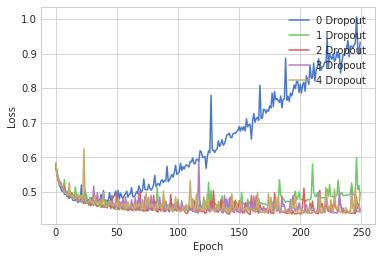

In [18]:
plt.plot(drop_0.history['val_loss'])
plt.plot(drop_1.history['val_loss'])
plt.plot(drop_2.history['val_loss'])
plt.plot(drop_3.history['val_loss'])
plt.plot(drop_4.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['0 Dropout', '1 Dropout', '2 Dropout', '3 Dropout', '4 Dropout'], loc='upper right')
plt.show()

## Choosing optimizer

In [19]:
# Training the network
batch_size = 8192
verbosity = 0 # 1 to see the output at each epoch
input_dim = xtrain.shape[1]

In [20]:
model = Sequential()
model.add(Dense(512, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
adam = model.fit(xtrain.values, ytrain, epochs=250, batch_size=batch_size, 
                 validation_split=0.2, verbose=verbosity)

In [21]:
scores = model.evaluate(xtest.values, ytest, batch_size=batch_size)
print('\nNeural Network with Adam optimizer testing {:.2f}%'.format(scores[1]*100))

90112/92636 [============================>.] - ETA: 0s
Neural Network with Adam optimizer testing 79.73%


In [22]:
model = Sequential()
model.add(Dense(512, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
sgd = model.fit(xtrain.values, ytrain, epochs=250, batch_size=batch_size, 
                validation_split=0.2, verbose=verbosity)

In [23]:
scores = model.evaluate(xtest.values, ytest, batch_size=batch_size)
print('\nNeural Network with SGD optimizer testing {:.2f}%'.format(scores[1]*100))

90112/92636 [============================>.] - ETA: 0s
Neural Network with SGD optimizer testing 70.50%


In [24]:
model = Sequential()
model.add(Dense(512, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
rmsprop = model.fit(xtrain.values, ytrain, epochs=250, batch_size=batch_size, 
                    validation_split=0.2, verbose=verbosity)

In [25]:
scores = model.evaluate(xtest.values, ytest, batch_size=batch_size)
print('\nNeural Network with RMSprop optimizer testing {:.2f}%'.format(scores[1]*100))

90112/92636 [============================>.] - ETA: 0s
Neural Network with RMSprop optimizer testing 76.14%


In [26]:
model = Sequential()
model.add(Dense(512, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
batch_size = 8192
nadam = model.fit(xtrain.values, ytrain, epochs=250, batch_size=batch_size, 
                  validation_split=0.2, verbose=verbosity)

In [27]:
scores = model.evaluate(xtest.values, ytest, batch_size=batch_size)
print('\nNeural Network with Nadam optimizer testing {:.2f}%'.format(scores[1]*100))

90112/92636 [============================>.] - ETA: 0s
Neural Network with Nadam optimizer testing 77.81%


In [28]:
model = Sequential()
model.add(Dense(512, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
batch_size = 8192
adamax = model.fit(xtrain.values, ytrain, epochs=250, batch_size=batch_size, 
                   validation_split=0.2, verbose=verbosity)

In [29]:
scores = model.evaluate(xtest.values, ytest, batch_size=batch_size)
print('\nNeural Network with Adamax optimizer testing {:.2f}%'.format(scores[1]*100))

90112/92636 [============================>.] - ETA: 0s
Neural Network with Adamax optimizer testing 79.73%


In [30]:
model = Sequential()
model.add(Dense(512, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
adagrad = model.fit(xtrain.values, ytrain, epochs=250, batch_size=batch_size, 
                    validation_split=0.2, verbose=verbosity)

In [31]:
scores = model.evaluate(xtest.values, ytest, batch_size=batch_size)
print('\nNeural Network with Adagrad optimizer testing {:.2f}%'.format(scores[1]*100))

90112/92636 [============================>.] - ETA: 0s
Neural Network with Adagrad optimizer testing 79.12%


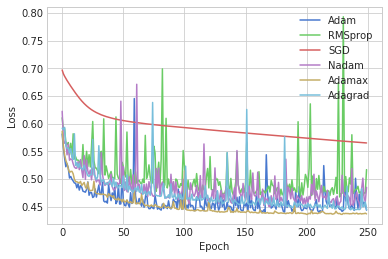

In [32]:
plt.plot(adam.history['val_loss'])
plt.plot(rmsprop.history['val_loss'])
plt.plot(sgd.history['val_loss'])
plt.plot(nadam.history['val_loss'])
plt.plot(adamax.history['val_loss'])
plt.plot(adagrad.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Adam', 'RMSprop', 'SGD', 'Nadam', 'Adamax', 'Adagrad'], loc='upper right')
plt.show()

# Multioutput predictions

In [33]:
xtrain_multi_raw, xtest_multi_raw, ytrain_multi_raw, ytest_multi_raw = get_data(data, detailed=True, scaled=True)
print(ytrain_multi_raw.unique())

78.39% (335978) of fights in the training dataset
21.61% (92636) of fights in the testing dataset
['kowin' 'koloss' 'decisionwin' 'submissionloss' 'submissionwin'
 'decisionloss']


In [34]:
# Map actual values to integers
mapping = {'kowin': 1, 'koloss': 2, 
           'decisionwin': 3, 'decisionloss': 4,
           'submissionloss': 5, 'submissionwin': 6}
ytrain_multi = ytrain_multi_raw.map(mapping)
ytest_multi = ytest_multi_raw.map(mapping)
xtrain_multi = xtrain_multi_raw
xtest_multi = xtest_multi_raw

In [35]:
# Find the most frequent value
counts = np.bincount(ytest_multi)
most_frequent_result = np.argmax(counts)
most_frequent = None
for key, value in mapping.items():
    if value == most_frequent_result:
        most_frequent = key

# Calculate the basic (most frequent prediction) accuracy      
most_frequents = len(data[data['result'] == most_frequent_result])
print('Basic accuracy is {:.2f}%'.format(max(counts)/len(ytest_multi)*100))
print('Most frequent result is {}'.format(most_frequent))

Basic accuracy is 18.33%
Most frequent result is kowin


In [36]:
# Change targets to categorical
ytrain_multi = to_categorical(ytrain_multi)
ytest_multi = to_categorical(ytest_multi)
# Training the network
batch_size = 8192
verbosity = 0 # 1 to see the output at each epoch
input_dim = xtrain_multi.shape[1]

In [37]:
model_multi = Sequential()
model_multi.add(Dense(512, input_dim=input_dim, activation='relu'))
model_multi.add(Dropout(0.2))
model_multi.add(Dense(256, activation='relu'))
model_multi.add(Dropout(0.2))
model_multi.add(Dense(128, activation='relu'))
model_multi.add(Dropout(0.2))
model_multi.add(Dense(64, activation='relu'))
model_multi.add(Dense(7, activation='sigmoid'))
model_multi.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
hist_multi = model_multi.fit(xtrain_multi.values, ytrain_multi, epochs=250, 
                             batch_size=batch_size, validation_split=0.2, verbose=verbosity)

In [38]:
scores = model_multi.evaluate(xtest_multi.values, ytest_multi, batch_size=batch_size)
print('\nNeural Network multiouput testing {:.2f}%'.format(scores[1]*100))

90112/92636 [============================>.] - ETA: 0s
Neural Network multiouput testing 62.05%


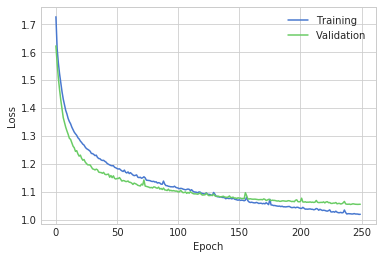

In [39]:
plt.plot(hist_multi.history['loss'])
plt.plot(hist_multi.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [40]:
rndf_multi = RandomForestClassifier(min_samples_split=25, random_state=42)
rndf_multi.fit(xtrain_multi, ytrain_multi)

print('RandomForestClassifier training {:.2f}%'.format(
    accuracy_score(ytrain_multi, rndf_multi.predict(xtrain_multi))*100))
print('RandomForestClassifier testing {:.2f}%'.format(
    accuracy_score(ytest_multi, rndf_multi.predict(xtest_multi))*100))
feats = {feature: importance for feature, importance in zip(xtrain_multi.columns, rndf_multi.feature_importances_)}
importances = pd.DataFrame.from_dict(feats, orient='index')
importances = importances.rename(columns={0: 'Importance', 1: 'Feature'})
importances = importances.iloc[importances['Importance'].abs().argsort()].iloc[::-1]
importances.head(5)

RandomForestClassifier training 35.81%
RandomForestClassifier testing 30.39%


,Importance
opponent_cumulative_win_win_submission,0.036654
fighter_cumulative_win_win_submission,0.036378
fighter_cumulative_win_win_total,0.030902
opponent_history_time,0.030038
opponent_cumulative_win_win_knockout,0.029178


# Final Model

In [41]:
# Training the network
batch_size = 8192
verbosity = 0 # 1 to see the output at each epoch
input_dim = xtrain.shape[1]

In [42]:
model = Sequential()
model.add(Dense(512, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
hist = model.fit(xtrain.values, ytrain, epochs=250, batch_size=batch_size, 
                 validation_split=0.2, verbose=verbosity)

In [43]:
scores = model.evaluate(xtest.values, ytest, batch_size=batch_size)
print('\nNeural Network testing {:.2f}%'.format(scores[1]*100))

90112/92636 [============================>.] - ETA: 0s
Neural Network testing 79.58%


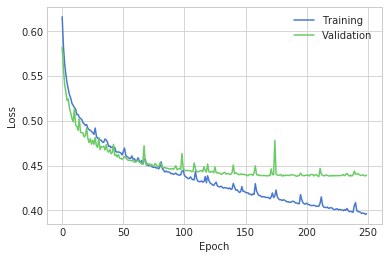

In [44]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

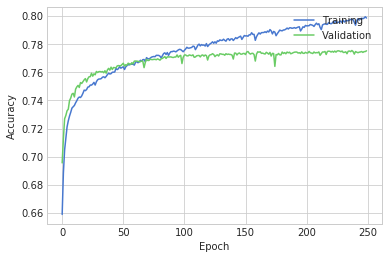

In [45]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Validate results

In [46]:
train, test = train_test_split(data)
test['predictions'] = model.predict(xtest.values)
test['fighterid'] = test['fighter'].apply(lambda x: x['id'])
test['opponentid'] = test['opponent'].apply(lambda x: x['id'])
results = test.drop(['fighter', 'opponent', 'set', 'id', 'location', 'details'], axis=1)

In [47]:
def show_organization_stats():
    """Prints accuracies per organization"""
    for organization in ['Ultimate Fighting Championship', 
                         'Bellator MMA',
                         'Jungle Fight',
                         'Konfrontacja Sztuk Walki',
                         'Absolute Championship Berkut']:
        subset = results[results['organization'] == organization]
        score = accuracy_score(subset['result'].map({'win': 1, 'loss': 0}), 
                               subset['predictions'].apply(lambda x: round(x)))
        print('{} accuracy score: {:.2f}%'.format(organization, score*100))

In [48]:
def show_yearly_stats():
    """Prints accuracies per years"""
    results['year'] = results['date'].apply(lambda x: x.year)
    for year in sorted(results['year'].unique().tolist()):
        subset = results[results['year'] == year]
        score = accuracy_score(subset['result'].map({'win': 1, 'loss': 0}),
                               subset['predictions'].apply(lambda x: round(x)))
        print('{} accuracy score: {:.2f}%'.format(year, score*100))

## Unique prediction per fight

In [49]:
# Extract all the ids from test set
ids = test['id'].unique()
fights = test.T.to_dict().values()

# Create fight pairs
pairs = {}
for fight in fights:
    idx = fight['id']
    if idx in pairs:
        pairs[idx].append(fight)
    else:
        pairs[idx] = [fight]

In [50]:
# Create unique predictions per fight
results = []
for key, pair in pairs.items():
    fighter = pair[0]
    opponent = pair[1]
    current = {'prediction': 0, 'result': 0}
    if fighter['predictions'] > opponent['predictions']:
        current['prediction'] = 1
    else:
        current['prediction'] = 0
        
    if fighter['result'] == 'win':
        current['result'] = 1
    else:
        current['result'] = 0
    
    results.append(current)

results = pd.DataFrame(results)

In [51]:
score = accuracy_score(results['result'], results['prediction'])
print('Accuracy score for unique predictions: {:.2f}%'.format(score*100))

Accuracy score for unique predictions: 79.72%
